## Stats507 Homework 8, April 3, 2019
### Israel Diego
#### israeldi@umich.edu

This notebook shows solutions to homework 8 for Stats507

## Table of Contents

1. [Problem 1: counting words with mrjob](#Problem-1:-counting-words-with-mrjob)
2. [Problem 2: Computing Sample Statistics with mrjob](#Problem-2:-Computing-Sample-Statistics-with-mrjob)
3. [Problem 3: Graph Processing: Counting Triangles with PySpark](#Problem-3:-Graph-Processing:-Counting-Triangles-with-PySpark)

### Problem 1: counting words with mrjob
#### Time Spent: 3 hours
#### ([Back to Top](#Table-of-Contents))
In this problem, you'll get a gentle introduction to `mrjob` and running `mrjob` on the Fladoop cluster. I have uploaded a large text file to the Fladoop cluster. Your job is to count how many times each word occurs in this file.
1. Write an `mrjob` job that takes text as input and counts how many times each word occurs in the text. Your script should strip punctuation like full stops, commas and semicolons, but you may treat hyphens, apostrophes, etc. as you wish. Simplest is to treat, e.g., "John's" as two words, "John" and "s", but feel free to do more complicated processing if you wish. Your script should ignore case, so that "Cat" and "cat" are considered the same word. Your output should be a collection of (word,count) pairs. Please save your script in a file called `mr_word_count.py` and include it in your submission.

In [35]:
# from mrjob.job import MRJob
# import string


# class MRWordCounts(MRJob):

#     def mapper(self, _, line):
#         # yield each word in the line
#         for word in line.split():
#         	yield (word.strip(string.punctuation).lower(), 1)

#     def combiner(self, word, counts):
#         # optimization: sum the words we've seen so far
#         yield (word, sum(counts))

#     def reducer(self, word, counts):
#         # optimization: sum the words we've seen so far
#         yield (word, sum(counts))


# if __name__ == '__main__':
#     MRWordCounts.run()

2. To test your code, I have uploaded a simple text file to the course webpage:
[http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/simple.txt](http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/simple.txt)
Download this file and test your code either on your local machine or on the Fladoop grid. The file is small enough that you should be able to check by hand whether your code is behaving correctly. Save the output of running your script on this small file to a file called `simple_word_counts.txt` and include it in your submission. **Note:** use the redirect arrow > to send the Hadoop output to a file. This will only send the `stdout` output to the file, while still printing the Hadoop error/status messages to the terminal.

In [36]:
# Command line: 

# python mr_word_count.py simple.txt > simple_word_counts.txt

3. Once you are confident in the correctness of your program, run your mrjob script on the file
[hdfs:/var/stat507w19/darwin.txt](hdfs:/var/stat507w19/darwin.txt)
on the Fladoop grid (this file is the Project Gutenberg plain text version of Charles Darwin's scientific work *On the Origin of Species*). Note that this file is on `hdfs`, not the local file system, so you'll have to run your script accordingly. Save the output to a file called `darwin_word_counts.txt`, and include it in your submission.

In [37]:
# Command line (in Flux): 

# python Stats_507/mr_word_count.py -r hadoop hdfs:///var/stats507w19/darwin.txt > Stats_507/darwin_word_counts.txt

4. Zipf's law states, roughly, that if one plots word frequency against frequency rank (i.e., most frequent word, second most frequent word, etc.), the resulting line is (approximately) linear on a log-log scale. Using the information in `darwin_word_counts.txt`, make a plot of word frequency as a function of word rank on a log-log scale for all words in the file
[hdfs:/var/stats507w19/darwin.txt](hdfs:/var/stats507w19/darwin.txt)
Give an appropriate title to your plot and include axis labels. Save the plot as a pdf file called `zipf.pdf`, and include it in your submission.

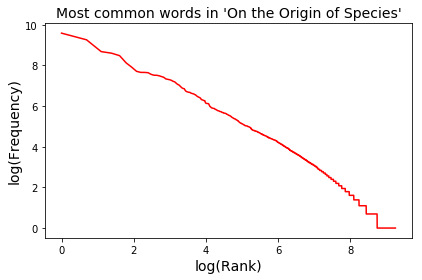

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd

file = "darwin_word_counts.txt"

data = []
rank = 1
with open(file) as f:
    # Extract input from file
    for line in f:
        word, freq = line.split()
        freq = int(freq)
        data.append([word, freq])
    
# Sort the Data by frequency, highest to lowest
data = sorted(data, key = lambda x: int(x[1]), reverse = True)

# Add rank to sorted data
for i in range(len(data)):
    data[i].insert(0, i + 1)
    
# Convert to dataframe to access columns easily
data = pd.DataFrame(data, columns = ["rank", "word", "frequency"])

# Plot our figure and save plot
f = plt.figure()
plt.plot(data["rank"].apply(math.log), data["frequency"].apply(math.log), 'r')
plt.title("Most common words in 'On the Origin of Species'", fontsize = 14)
plt.xlabel('log(Rank)', fontsize = 14)
plt.ylabel('log(Frequency)', fontsize = 14)
_ = plt.tight_layout()

f.savefig("zipf.pdf", bbox_inches='tight')

5. How "Zipfian" does the resulting plot look (It suffices for you to state whether or not your plot looks approximately like a line)? You can read more about Zipf's law and about power laws generally at the respective Wikipedia pages (https://en.wikipedia.org/wiki/Zipf's_law, https://en.wikipedia.org/wiki/Power_law). For more about power laws, I recommend this survey paper by Mark Newman, a faculty member here at University of Michigan https://arxiv.org/pdf/cond-mat/0412004.pdf.

- *It is safe to say that the plot from Problem 1.4 is linear.*

### Problem 2: Computing Sample Statistics with mrjob
#### Time Spent: 5 hours
#### ([Back to Top](#Table-of-Contents))
In this problem, we'll compile some very basic statistics summarizing a toy dataset. The file 

http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/populations_small.txt

contains a collection of (class,value) pairs, one per line, with each line taking the form `class_label, value`, where `class_label` is a nonnegative integer and `value` is a float. Each pair corresponds to an observation, with the class labels corresponding to different populations, and the values corresponding to some measured quantity.
1. Write a `mrjob` program called `mr_summary_stats.py` that takes as input a sequence of (label,value) pairs like in the file at http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/populations_small.txt, and outputs a collection of (label, number of samples, mean, variance) $4$-tuples, in which one $4$-tuple appears for each class label in the data, and the mean and variance are the sample mean and variance, respectively, of all the values for that class label. Thus, if $25$ unique class labels are present in the input then your program should output $25$ lines, one for each class label. **Note:** I don't care whether you use $n$ or $n-1$ in the denominator of your sample variance formula, just be clear which one you are using. **Note:** you don't need to do any special formatting of the Hadoop output. That is, your output is fine if it consists of lines of the form `label` `[number,mean,variance]` or similar.

Think carefully about what your key-value pairs should be here, as well as what your mappers, reducers, etc. should be. Should there be more than one step in your job? Sit down with pen and paper first! **Hint:** to compute the sample mean and sample variance of a collection of numbers, it suffices to know their sum, the sum of their squares, and the size of the collection.

Please include a copy of `mr_summary_stats.py` in your submission.

In [39]:
# from mrjob.job import MRJob
# import functools

# class MRSummaryStats(MRJob):

#     def mapper(self, _, line):
#         # yield label as the key, and a tuple of values necessary for computation of mean and sample variance
#         label, value = line.split()
#         value = float(value)
#         yield (label, (1, value, value**2))

#     def combiner(self, label, values):
#         # calculate our sample mean and sample variance
#         n, sumX, sumX2 = functools.reduce(lambda x,y:[x[i] + y[i] for i in range(len(y))], values)
#         yield label, (n, sumX / n, (sumX2 / n) - (sumX / n)**2)

#     def reducer(self, label, values):
#         # calculate our sample mean and sample variance
#         n, sumX, sumX2 = functools.reduce(lambda x,y:[x[i] + y[i] for i in range(len(y))], values)
#         yield label, (n, sumX / n, (sumX2 / n) - (sumX / n)**2)


# if __name__ == '__main__':
#     MRSummaryStats.run()

2. Download the small file at http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/populations_small.txt. Run your `mrjob` script on this file, either on your local machine or on Fladoop, and write the output to a file called `summary_small.txt`. Please include this file in your submission. Inspect your program's output and verify that it is behaving as expected.

In [40]:
# Command Line: 

# python mr_summary_stats.py populations_small.txt > summary_small.txt

3. I have uploaded to the Fladoop cluster a much larger data file, located on the HDFS file system at [hdfs:/var/stats507w19/populations_large.txt](hdfs:/var/stats507w19/populations_large.txt). Once you are *sure* that your script is doing what you want, run it on this file. Be sure to use the `-r hadoop` command to tell `mrjob` to run on the Hadoop server rather than on the login node. Save the output to a file called `summary_large.txt`. Download this file and include it in your submission. Please also include in your notebook file a copy-paste of your shell session on Fladoop in a markdown cell (i.e., a cell that will display as code but will not be executed by the interpreter).

In [41]:
# Command Line:

# python Stats_507/mr_summary_stats.py -r hadoop hdfs:///var/stats507w19/populations_large.txt > Stats_507/summary_large.txt

[israeldi@flux-hadoop-login2 ~]$ python Stats_507/mr_summary_stats.py -r hadoop hdfs:///var/stats507w19/populations_large.txt > Stats_507/summary_large.txt
Using configs in /etc/mrjob.conf
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.7.3.2.6.3.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/mr_summary_stats.israeldi.20190405.205834.347413
Copying local files to hdfs:///user/israeldi/tmp/mrjob/mr_summary_stats.israeldi.20190405.205834.347413/files/...
Running step 1 of 1...
  packageJobJar: [] [/usr/hdp/2.6.3.0-235/hadoop-mapreduce/hadoop-streaming-2.7.3.2.6.3.0-235.jar] /tmp/streamjob7344297405908316377.jar tmpDir=null
  Connecting to ResourceManager at fladoop-rm01.arc-ts.umich.edu/10.164.5.157:8050
  Connecting to Application History server at fladoop-rm01.arc-ts.umich.edu/10.164.5.157:10200
  Connecting to ResourceManager at fladoop-rm01.arc-ts.umich.edu/10.164.5.157:8050
  Connecting to Application History server at fladoop-rm01.arc-ts.umich.edu/10.164.5.157:10200
  Created HDFS_DELEGATION_TOKEN token 139614 for israeldi on 10.164.5.158:8020
  Got dt for hdfs://fladoop-nn02.arc-ts.umich.edu:8020; Kind: HDFS_DELEGATION_TOKEN, Service: 10.164.5.158:8020, Ident: (HDFS_DELEGATION_TOKEN token 139614 for israeldi)
  Total input paths to process : 1
  Adding a new node: /default-rack/10.164.1.144:1019
  Adding a new node: /default-rack/10.164.1.140:1019
  Adding a new node: /default-rack/10.164.1.143:1019
  Adding a new node: /default-rack/10.164.1.141:1019
  Adding a new node: /default-rack/10.164.1.142:1019
  Adding a new node: /default-rack/10.164.1.145:1019
  number of splits:2
  Submitting tokens for job: job_1547074859606_16460
  Kind: HDFS_DELEGATION_TOKEN, Service: 10.164.5.158:8020, Ident: (HDFS_DELEGATION_TOKEN token 139614 for israeldi)
  Timeline service address: http://fladoop-rm01.arc-ts.umich.edu:8188/ws/v1/timeline/
  Submitted application application_1547074859606_16460
  The url to track the job: http://fladoop-rm01.arc-ts.umich.edu:8088/proxy/application_1547074859606_16460/
  Running job: job_1547074859606_16460
  Job job_1547074859606_16460 running in uber mode : false
   map 0% reduce 0%
   map 8% reduce 0%
   map 13% reduce 0%
   map 19% reduce 0%
   map 24% reduce 0%
   map 29% reduce 0%
   map 35% reduce 0%
   map 40% reduce 0%
   map 45% reduce 0%
   map 51% reduce 0%
   map 56% reduce 0%
   map 61% reduce 0%
   map 66% reduce 0%
   map 67% reduce 0%
   map 83% reduce 0%
   map 100% reduce 0%
   map 100% reduce 100%
  Job job_1547074859606_16460 completed successfully
  Output directory: hdfs:///user/israeldi/tmp/mrjob/mr_summary_stats.israeldi.20190405.205834.347413/output
Counters: 49
	File Input Format Counters 
		Bytes Read=153028684
	File Output Format Counters 
		Bytes Written=1056
	File System Counters
		FILE: Number of bytes read=2476
		FILE: Number of bytes written=489934
		FILE: Number of large read operations=0
		FILE: Number of read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=153028946
		HDFS: Number of bytes written=1056
		HDFS: Number of large read operations=0
		HDFS: Number of read operations=9
		HDFS: Number of write operations=2
	Job Counters 
		Launched map tasks=2
		Launched reduce tasks=1
		Rack-local map tasks=2
		Total megabyte-milliseconds taken by all map tasks=277889024
		Total megabyte-milliseconds taken by all reduce tasks=22872064
		Total time spent by all map tasks (ms)=135688
		Total time spent by all maps in occupied slots (ms)=271376
		Total time spent by all reduce tasks (ms)=5584
		Total time spent by all reduces in occupied slots (ms)=22336
		Total vcore-milliseconds taken by all map tasks=135688
		Total vcore-milliseconds taken by all reduce tasks=5584
	Map-Reduce Framework
		CPU time spent (ms)=150370
		Combine input records=10000000
		Combine output records=50
		Failed Shuffles=0
		GC time elapsed (ms)=731
		Input split bytes=262
		Map input records=10000000
		Map output bytes=409729324
		Map output materialized bytes=2482
		Map output records=10000000
		Merged Map outputs=2
		Physical memory (bytes) snapshot=3372437504
		Reduce input groups=25
		Reduce input records=50
		Reduce output records=25
		Reduce shuffle bytes=2482
		Shuffled Maps =2
		Spilled Records=100
		Total committed heap usage (bytes)=3726114816
		Virtual memory (bytes) snapshot=13179109376
	Shuffle Errors
		BAD_ID=0
		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
job output is in hdfs:///user/israeldi/tmp/mrjob/mr_summary_stats.israeldi.20190405.205834.347413/output
Streaming final output from hdfs:///user/israeldi/tmp/mrjob/mr_summary_stats.israeldi.20190405.205834.347413/output...
Removing HDFS temp directory hdfs:///user/israeldi/tmp/mrjob/mr_summary_stats.israeldi.20190405.205834.347413...
Removing temp directory /tmp/mr_summary_stats.israeldi.20190405.205834.347413...

4. Use `matplotlib` and the results in `summary_large.txt` to create a plot displaying $95\%$ confidence intervals for the sample means of the populations given by the class labels in file [hdfs:/var/stats507w19/populations_large.txt](hdfs:/var/stats507w19/populations_large.txt). You will probably want to make a boxplot for this, but feel free to get creative if you think you have a better way to display the information. Make sure your plot has a sensible title and axis labels. Save your plot as a pdf called `populations.pdf` and include it in your submission.

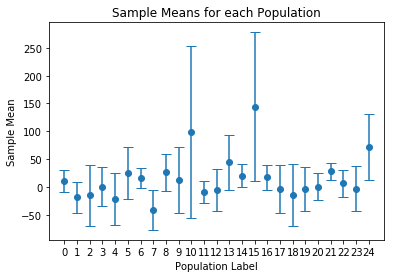

In [42]:
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

cols = ['n', 's_mean', 's_var']

# Read Data
df = pd.read_table('summary_large.txt', delim_whitespace = True, names = ('label', 'Stats'))
df

# Separate into separate columns from our Stats column
df['Stats'] = df['Stats'].apply(lambda x: pd.Series(str(x).replace('[', '')))
df['Stats'] = df['Stats'].apply(lambda x: pd.Series(str(x).replace(']', '')))
df[cols] = df['Stats'].apply(lambda x: pd.Series(str(x).split(',')))

# Convert columns to numeric
df[cols] = df[cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

# Sort by population labels
df = df.sort_values(by = ['label'])

# Set up Error bars for our plot
x_pos = np.arange(len(df))
error = ((df['s_var'] / df['n']).apply(np.sqrt))* 1.96

# Plot our Bar chart with 95% confidence bands
f = plt.figure()
plt.errorbar(x_pos, df['s_mean'], yerr = error, capsize = 5, fmt = 'o')
plt.title('Sample Means for each Population')
plt.ylabel('Sample Mean')
plt.xlabel('Population Label')
_=plt.xticks(x_pos, df['label'])


f.savefig("populations.pdf", bbox_inches='tight')

### Problem 3: Graph Processing: Counting Triangles with PySpark
#### Time Spent: 6 hours
#### ([Back to Top](#Table-of-Contents))

A classic task in graph processing is called "triangle counting". If you have never heard of graphs, that's okay! It suffices to know that a graph is a set of *nodes* (also called *vertices*), pairs of which are joined by *edges* (see https://en.wikipedia.org/wiki/Graph_theory for more). A *triangle* in graph theory is a set of three nodes, say $\{a, b, c\}$, such that all three nodes are joined by edges. Triangle counting is closely related to a fundamental task for social media companies, who may wish to suggest new "friends" to users based on their existing social network. In this problem, you'll implement triangle counting in the MapReduce framework using PySpark. We should note that in practice, the MapReduce framework is rather poorly-suited to the problem of counting triangles, but it's a good problem to get you practice with the framework, so we'll leave that be.

The input for this problem will be a collection of files representing users' friend lists in a social network. Each user in the network is assigned a numeric ID, and that user's friend list is contained in a file called `n.txt`, where `n` is the user's ID. Each such file contains a single space-separated line, of the form

`n f1 f2 ... fK`

where `n` is the node and `f1,f2,...,fK` are the IDs of the friends of `n`. So, if node $1$ is friends with nodes $2,5$ and $6$, there will be a file `1.txt`, containing only the line `1 2 5 6`. If node $10$ has no friends, then there will be a file `10.txt`, containing only the line `10`, or perhaps no file at all. Note that just because an ID appears in a friend list, that doesn't necessarily mean that there will be a file listing that user's friends, but you may assume (1) **symmetry:** if $100$ is a friend of $200$, then $200$ is a friend of $100$. (2) **no duplication**: each friend appears in a given friend list at most once (i.e., every file will contain a given number at most once).

Once again, before you dive in and write a bunch of code, sit down and think about the problem. What is the right "fundamental unit" of the problem? What should your keys and values look like? **Hint:** the simplest solution to this problem involves multiple steps, involving a standard map-reduce pattern and a subsequent filtering operation. As usual, overly complicated solutions will not receive full credit.
1. Write a PySpark job that takes the described input and produces a list of all the triangles in the network, one per line. Each triangle should be listed as a space-separated line `node1 node2 node3`, with the entries sorted numerically in ascending order. So, if nodes $2$, $5$ and $15$ form a triangle, the output should include the triple $(2,5,15)$, but not $(2,15,5)$, $(15,2,5)$, etc. Save your script in a file called `ps_fof.py` and include it in your submission.

In [43]:
# from pyspark import SparkConf,SparkContext
# import sys
# import itertools, functools

# # At first are the configuration settings so we can run it through the terminal
# # then we set up configuration for the PySpark job
# if len(sys.argv) != 3:
#     print('Usage: ' + sys.argv[0] + ' <in> <out>') # [0] will be the .py file
#     sys.exit(1)
# inputlocation = sys.argv[1] # [1] will be the input file(i.e. the txt files here)
# outputlocation = sys.argv[2] # [2] where we save the output of the program

# # Set up the configuration and job context
# conf = SparkConf().setAppName('Triangles') 
# sc = SparkContext(conf = conf) 

# # Read Files ----------------------------------------------------------------------------------------------------
# data = sc.textFile(inputlocation)

# # Split line, convert to ints, format as (key,value) pairs where node n is the key, and its friends are the values
# data = data.map(lambda line: [num for num in line.split()]).map(lambda numList: [int(num) for num in numList]).map(lambda numList: (numList[0], numList[1:]))

# # Get all combinations of pairs of friends for each key. (n choose 2)
# combs = data.map(lambda w: [w[0], list(itertools.combinations(w[1], 2))])

# # Create all possible triangles
# triangles = combs.flatMapValues(lambda x: x).map(lambda w: (w[0], w[1][0], w[1][1]))

# # Sort each tuple
# triangles = triangles.map(lambda w: tuple(sorted(w)))

# # Set up to be used as dictionary and count by key/ filter out the "fake" triangles that only show up once
# triangles = triangles.map(lambda w: (w, 0))
# triangles = triangles.countByKey()
# triangles = list(filter(lambda x: x[1] > 1, triangles.items()))

# # Convert list to RDD again in order to sort output and convert data to string
# triangles = sc.parallelize(triangles)
# data_final = triangles.map(lambda w: w[0]).collect()
# data_final = sorted(data_final)

# # Convert to space-separated
# data_final = sc.parallelize(data_final)
# data_final = data_final.map(str).map(lambda w: w.strip('(),'))
# data_final = data_final.map(lambda w: w.replace(',', ''))

# # Save Output ----------------------------------------------------------------------------------------------------
# data_final.saveAsTextFile(outputlocation)
# sc.stop() # Let Spark know that the job is done.

2. Test your script on the set of 5 simple files in the HDFS directory
[hdfs:/var/stats507w19/fof/friends.simple](hdfs:/var/stats507w19/fof/friends.simple)
which is small enough that you should be able to work out by hand what the correct output is. How many triangles are there? List them in a file called `small_triangle_list.txt` and include it in your submission.

In [44]:
# COMMAND LINE:

# spark-submit --master yarn --queue stats507w19 Stats_507/ps_fof.py /var/stats507w19/fof/friends.simple Stats_507/small_triangle_list
   
# Get number of triangles
df = pd.read_table('small_triangle_list.txt', delim_whitespace = True, header = None)
numTriangles = len(df)

print("Number of Triangles in Small List = ", numTriangles)

Number of Triangles in Small List =  6


3. Once you are confident that your script is correct, run it on the larger data set, stored on HDFS at [hdfs:/var/stats507w19/fof/friends1000](hdfs:/var/stats507w19/fof/friends1000) Save the list of triangles to a file called big `big_triangle_list.txt`, and include it in your submission. Don't forget to include in your notebook file a copy-paste of the commands you used to launch your job along with their outputs.

In [45]:
# COMMAND LINE:

# spark-submit --master yarn --queue stats507w19 Stats_507/ps_fof.py /var/stats507w19/fof/friends1000 Stats_507/big_triangle_list

# Get number of triangles
df = pd.read_table('big_triangle_list.txt', delim_whitespace = True, header = None)
numTriangles = len(df)

print("Number of Triangles in Big List = ", numTriangles)

Number of Triangles in Big List =  144120
